#Midterm Project
##Banknote Authentication - UCI ML Repository
### Liam McKenzie



*Note to reader:*  
*Graphical representations of data were generated using code generated by Claude Sonnet 4.5, cited at each instance. Additional helper functions generated by Claude Sonnet 4.5 are also credited throughout the project, where applicable.*

Set imports


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, recall_score, classification_report

Get dataset from UCI Repository

In [30]:
url='https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/banknote_authentication.csv'
columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
notesDF = pd.read_csv(url, names = columns)
notesDF.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


#1. Describe dataset

This data set contains 1,372 banknote records used to differentiate genuine and forged bills. Data was extracted from images taken of genuine and forged banknote-like specimens.

The primary source of the data is from the UCI Repository: https://archive.ics.uci.edu/dataset/267/banknote+authentication  

A downloadable CSV, used in this notebook, was extracted from https://raw.githubusercontent.com/jbrownlee/Datasets/refs/heads/master/banknote_authentication.csv

Feature variables are:
- variance (of Wavelet Transformed image)
- skewness (of Wavelet Transformed image)
- curtosis (of Wavelet Transformed image)
- entropy  (of Wavelet Transformed image)  
All of these variables define characteristics of a banknote image procesed by Wavelet Transform tool.  

Target variable is:
- class (classification of banknote, genuine/counterfeit)  
This dataset uses 0/1 to represent genuine(0)/and counterfeit(1).

Classification will be used to perform this analysis. This analysis will use a **binary classification** to the dataset because the class value has two options: genuine or forged.

#2. Data Cleaning

In [31]:
#check for missing values
notesDF.isnull().sum()

,0
variance,0
skewness,0
curtosis,0
entropy,0
class,0


There are no missing values. No imputation techniques are required.

In [32]:
#check column value types
notesDF.dtypes

,0
variance,float64
skewness,float64
curtosis,float64
entropy,float64
class,int64


Since class is supposed to be of type object, we can change the values to the string representation of 0 and 1 in this context.

In [33]:
#change class column values from 0/1 to genuine/forged
notesDF['class'] = notesDF['class'].replace({0:'genuine', 1:'forged'})
notesDF.head()


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,genuine
1,4.54590,8.1674,-2.4586,-1.46210,genuine
2,3.86600,-2.6383,1.9242,0.10645,genuine
3,3.45660,9.5228,-4.0112,-3.59440,genuine
4,0.32924,-4.4552,4.5718,-0.98880,genuine


In [34]:
#confirm conversion
notesDF.dtypes

,0
variance,float64
skewness,float64
curtosis,float64
entropy,float64
class,object


Because the class column needed to be converted to type object, each value needed to be encoded using LabelEncoder so the DTree model can use the information.

In [35]:
#encode class column using LablEncoder from scikit.learn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
notesDF['class'] = le.fit_transform(notesDF['class'])

# 3. Preliminary Data Analysis

In [36]:
#count number of rows and columns
notesDF.shape

(1372, 5)

In [37]:
#use describe count to analyze basic statistics of data set
notesDF.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.555394
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,1.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


The dataset is 5 columns wide by 1372 rows deep.

Variance data points are relatively centered around 0 with a nearly even spread based on quartiles.  

Skewness has a very high standard deviation and the mean value appears to be on the higher end of the quartiles. This could suggest that the data is skewed right, but still has extreme values across the whole dataset.  

Curtosis also has a very high standard deviation and a highly positive mean value, which is over the 50th percentile. This indicates a very high skew to the upper quartiles.  

Entropy has a negative mean which indicates on average there is less randomness across banknotes. Given that the minimum value is much lower than the max is high, this shows that generally, there is more uniformity.

Class mean paired with a 50th-max percentile of 1, suggests ~55% of the banknotes are forged (1) and only ~45% are genuine (0).

# 4. Exploratory Analysis using Visual Tools

/tmp/ipython-input-2108228723.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=notesDF, x='class', palette=colors, ax=ax2)
/tmp/ipython-input-2108228723.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Genuine', 'Forged'])


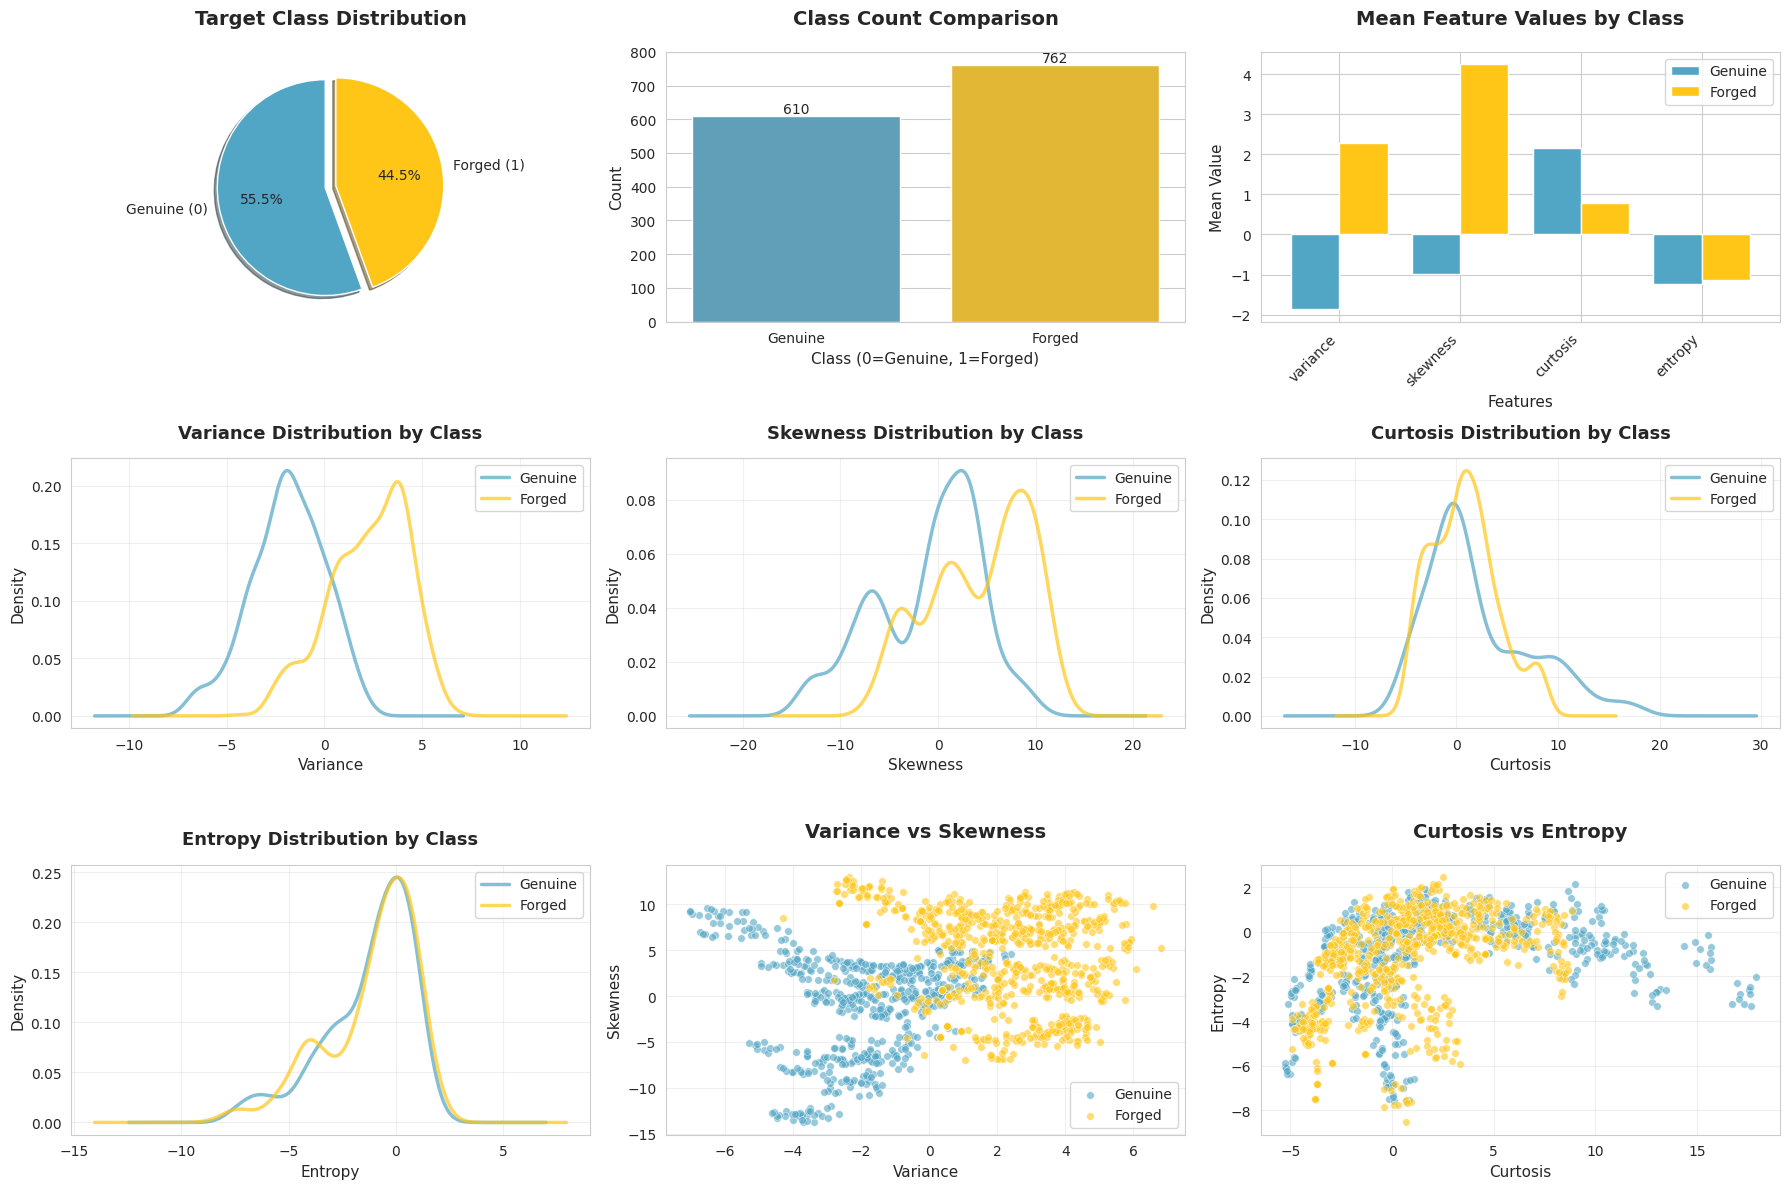

In [38]:
#I used Claude Sonnet 4.5 to help build the graphs for this section
#==================================================================#

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. PIE CHART - Class Distribution
ax1 = plt.subplot(3, 3, 1)
class_counts = notesDF['class'].value_counts()
colors = ['#51a5c5', '#ffc618']
labels = ['Genuine (0)', 'Forged (1)']
explode = (0.05, 0.05)

ax1.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, shadow=True)
ax1.set_title('Target Class Distribution', fontsize=14, fontweight='bold', pad=20)

# 2. BAR CHART - Class Counts
ax2 = plt.subplot(3, 3, 2)
sns.countplot(data=notesDF, x='class', palette=colors, ax=ax2)
ax2.set_title('Class Count Comparison', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Class (0=Genuine, 1=Forged)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_xticklabels(['Genuine', 'Forged'])

# Add count labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fontsize=10)

# 3. BAR CHART - Feature Means by Class
ax3 = plt.subplot(3, 3, 3)
feature_means = notesDF.groupby('class')[['variance', 'skewness', 'curtosis', 'entropy']].mean()
feature_means.T.plot(kind='bar', ax=ax3, color=colors, width=0.8)
ax3.set_title('Mean Feature Values by Class', fontsize=14, fontweight='bold', pad=20)
ax3.set_xlabel('Features', fontsize=11)
ax3.set_ylabel('Mean Value', fontsize=11)
ax3.legend(['Genuine', 'Forged'], loc='upper right')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4-7. DENSITY PLOTS for each feature
features = ['variance', 'skewness', 'curtosis', 'entropy']
for idx, feature in enumerate(features, start=4):
    ax = plt.subplot(3, 3, idx)

    # Plot density for each class
    for class_val, color, label in zip([0, 1], colors, ['Genuine', 'Forged']):
        data = notesDF[notesDF['class'] == class_val][feature]
        data.plot(kind='density', ax=ax, color=color, label=label, linewidth=2.5, alpha=0.7)

    ax.set_title(f'{feature.capitalize()} Distribution by Class', fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel(feature.capitalize(), fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

# 8. SCATTER PLOT - Variance vs Skewness
ax8 = plt.subplot(3, 3, 8)
for class_val, color, label in zip([0, 1], colors, ['Genuine', 'Forged']):
    data = notesDF[notesDF['class'] == class_val]
    ax8.scatter(data['variance'], data['skewness'], c=color, label=label,
                alpha=0.6, s=30, edgecolors='white', linewidth=0.5)

ax8.set_title('Variance vs Skewness', fontsize=14, fontweight='bold', pad=20)
ax8.set_xlabel('Variance', fontsize=11)
ax8.set_ylabel('Skewness', fontsize=11)
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. SCATTER PLOT - Curtosis vs Entropy
ax9 = plt.subplot(3, 3, 9)
for class_val, color, label in zip([0, 1], colors, ['Genuine', 'Forged']):
    data = notesDF[notesDF['class'] == class_val]
    ax9.scatter(data['curtosis'], data['entropy'], c=color, label=label,
                alpha=0.6, s=30, edgecolors='white', linewidth=0.5)

ax9.set_title('Curtosis vs Entropy', fontsize=14, fontweight='bold', pad=20)
ax9.set_xlabel('Curtosis', fontsize=11)
ax9.set_ylabel('Entropy', fontsize=11)
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. **Class Distribution** *Pie Chart*:
   Shows the balance between genuine (44.5%) and forged (55.5%) banknotes.
   Reveals slight class imbalance with more forged notes in the dataset.  

2. **Class Count Comparison** *Bar Chart*:
   Displays the actual count of each class (610 genuine, 762 forged).
   Confirms the dataset has adequate samples of both classes for training.  

3. **Mean Feature Values by Class** *Bar Chart*:
   Compares average values of all four features between genuine and forged notes.
   Shows which features have notably different means between classes.  

4. **Variance Distribution** *Density Plot*:
   Shows how variance values are distributed for each class.
   Overlapping distributions suggest variance helps but doesn't perfectly separate classes.  

5. **Skewness Distribution** *Density Plot*:
   Displays the spread and peaks of skewness values for genuine vs forged.
   Wide spread and different peaks show skewness is a strong discriminator.  

6. **Curtosis Distribution** *Density Plot*:
   Illustrates how curtosis values differ between genuine and forged banknotes.
   Distinct distribution patterns indicate curtosis captures different textures.  

7. **Entropy Distribution** *Density Plot*:
   Shows the distribution of entropy (randomness) in banknote images.
   Clear separation suggests entropy is highly predictive for classification.  

8. **Variance vs Skewness** *Scatter Plot*:
   Visualizes the relationship between two features, colored by class.
   Reveals clustering patterns showing how these features together separate classes.  

9. **Curtosis vs Entropy** *Scatter Plot*:
   Plots the relationship between curtosis and entropy for each class.
   Shows whether feature combinations create distinct regions for classification.  


Key Insights:
- Density plots reveal which features have the most separation between classes
- Scatter plots show whether features work together to create clusters
- All features show some discriminative power, justifying their inclusion
- The overlaps in distributions explain why a model is needed rather than
  simple threshold rules

*Note: Claude Sonnet 4.5 helped ensure formatting and tone was uniform through the explanation section*

# 5. Build Models

In [39]:
#split features and target variable
xData = notesDF[['variance', 'skewness', 'curtosis', 'entropy']]
yData = notesDF['class']

In [40]:
#split into train and test sets (80-20 split)
xTrain, xTest, yTrain, yTest = train_test_split(
    xData, yData, test_size=0.2, random_state=42, stratify=yData
)

In [41]:
print("LOW COMPLEXITY MODEL (max_depth=3)")
print("\n")

dtreeLow = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
dtreeLow.fit(xTrain, yTrain)

predTrainLow = dtreeLow.predict(xTrain)
predTestLow = dtreeLow.predict(xTest)

trainAccuracyLow = accuracy_score(yTrain, predTrainLow)
testAccuracyLow = accuracy_score(yTest, predTestLow)

print(f"Train Accuracy: {trainAccuracyLow:.4f}")
print(f"Test Accuracy: {testAccuracyLow:.4f}")
print(f"Overfit Gap: {trainAccuracyLow - testAccuracyLow:.4f}")
print(f"Tree Depth: {dtreeLow.get_depth()}")
print(f"Number of Leaves: {dtreeLow.get_n_leaves()}")

LOW COMPLEXITY MODEL (max_depth=3)


Train Accuracy: 0.9599
Test Accuracy: 0.9200
Overfit Gap: 0.0399
Tree Depth: 3
Number of Leaves: 8


In [42]:
print("HIGH COMPLEXITY MODEL (max_depth=None)")
print("\n")

dtreeHigh = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
dtreeHigh.fit(xTrain, yTrain)

predTrainHigh = dtreeHigh.predict(xTrain)
predTestHigh = dtreeHigh.predict(xTest)

trainAccuracyHigh = accuracy_score(yTrain, predTrainHigh)
testAccuracyHigh = accuracy_score(yTest, predTestHigh)

print(f"Train Accuracy: {trainAccuracyHigh:.4f}")
print(f"Test Accuracy: {testAccuracyHigh:.4f}")
print(f"Overfit Gap: {trainAccuracyHigh - testAccuracyHigh:.4f}")
print(f"Tree Depth: {dtreeHigh.get_depth()}")
print(f"Number of Leaves: {dtreeHigh.get_n_leaves()}")

HIGH COMPLEXITY MODEL (max_depth=None)


Train Accuracy: 1.0000
Test Accuracy: 0.9818
Overfit Gap: 0.0182
Tree Depth: 7
Number of Leaves: 20


The low complexity model is underfitting because the training accuracy is much lower than the high complexity model which indicates that the model is not capturing all of the patterns in the data. With only 3 levels of depth and 8 leaves, the model is too simple to make decisions based on the boundaries needed to distinguish genuine from forged banknotes. This can result in high bias where the model makes simplistic assumptions about the data, potentially predicting inaccurately.

The low complexity model makes a maximum of 3 comparisons from root to leaf.

In [43]:
from sklearn.tree import export_text

tree_rules = export_text(dtreeLow,
                         feature_names=['variance', 'skewness', 'curtosis', 'entropy'])
print(tree_rules)

|--- variance <= 0.32
|   |--- skewness <= 7.57
|   |   |--- variance <= -1.78
|   |   |   |--- class: 0
|   |   |--- variance >  -1.78
|   |   |   |--- class: 0
|   |--- skewness >  7.57
|   |   |--- variance <= -4.73
|   |   |   |--- class: 0
|   |   |--- variance >  -4.73
|   |   |   |--- class: 1
|--- variance >  0.32
|   |--- variance <= 1.79
|   |   |--- curtosis <= -2.24
|   |   |   |--- class: 0
|   |   |--- curtosis >  -2.24
|   |   |   |--- class: 1
|   |--- variance >  1.79
|   |   |--- variance <= 2.23
|   |   |   |--- class: 1
|   |   |--- variance >  2.23
|   |   |   |--- class: 1



The primary decision the low complexity tree makes, is to determine what the value of variance is. Depending on variance level, the model checks skewness, then variance again to determine classification of the banknote.  
For example, the variance is 0.32 **AND** skewness is > 7.57 **AND** variance is > -4.78 the banknote is forged.

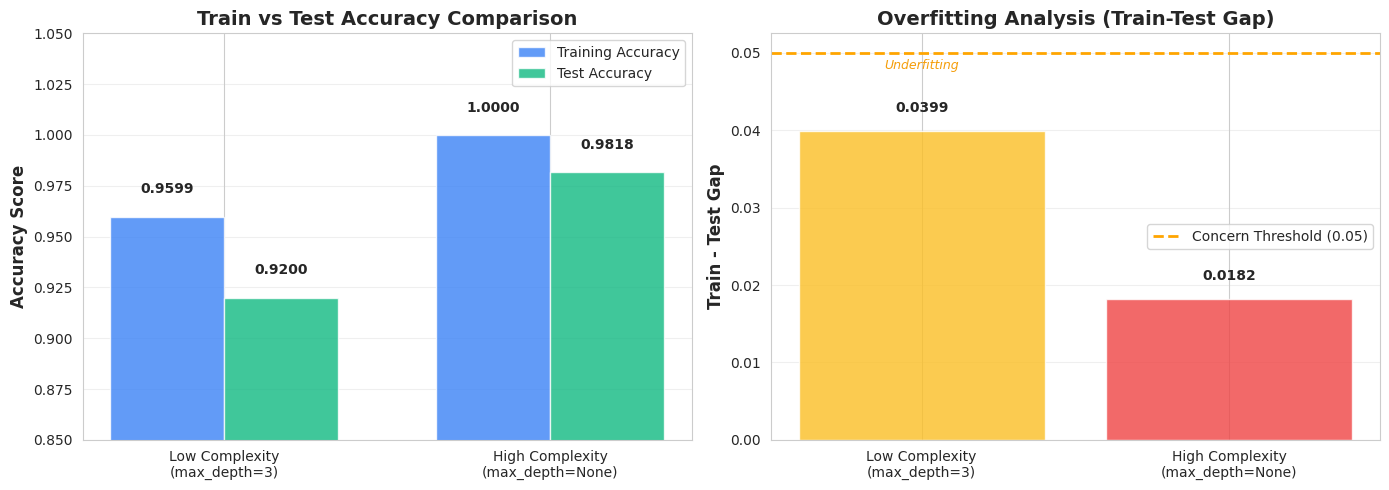

In [44]:
#Claude Sonnet 4.5 helped create these charts

# Model names and scores
models = ['Low Complexity\n(max_depth=3)', 'High Complexity\n(max_depth=None)']
train_scores = [0.9599, 1.0000]
test_scores = [0.9200, 0.9818]
gaps = [0.0399, 0.0182]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Accuracy
ax1 = axes[0]
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(x - width/2, train_scores, width, label='Training Accuracy',
                color='#3b82f6', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_scores, width, label='Test Accuracy',
                color='#10b981', alpha=0.8)

ax1.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax1.set_title('Train vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.set_ylim([0.85, 1.05])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Overfitting Gap
ax2 = axes[1]
colors = ['#fbbf24', '#ef4444']  # Yellow for low gap, red for concerning gap

bars = ax2.bar(models, gaps, color=colors, alpha=0.8)
ax2.axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Concern Threshold (0.05)')
ax2.set_ylabel('Train - Test Gap', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Analysis (Train-Test Gap)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add interpretation labels
    if i == 0:
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.008,
                'Underfitting', ha='center', fontsize=9, style='italic', color='#f59e0b')

plt.tight_layout()
plt.show()


The high complexity model overfits because it has high depth 7 levels
and 20 leaves, allowing it to create highly specific decision rules that
memorize every detail of the training data, achieving perfect 100% accuracy.
These complex rules capture noise and random variations in the training
set rather than true patterns, which is why performance slightly drops to 98.18%
on unseen test data. The model memorizes the training examples
instead of learning generalizable patterns that apply to new banknotes.

To prevent overfitting, two methods can be used.
1. By limiting tree depth, we can restrict how deep the tree can grow to
   prevent overly specific rules, for example set max_depth=5 instead of unlimited.

5. By using cross-validation techniques, we can use k-fold cross-validation to evaluate model performance across multiple data subsets, ensuring it generalizes well.


In [45]:
#5 fold cross validation with data shuffle
crossVal = KFold(n_splits=5,  shuffle = True)

#setting up grid search
model = tree.DecisionTreeClassifier()
param_grid = {
    'max_depth': list(range(1,11)),
    'criterion': ['entropy', 'gini']
    }
grid = GridSearchCV(model, param_grid, cv=5)

#performing grid search
grid.fit(xTrain, yTrain)

print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.4f}".format(grid.best_score_))
print("Test set score: {:.4f}".format(grid.score(xTest, yTest)))
print("Tree depth: {}".format(grid.best_estimator_.get_depth()))
print("Number of leaves: {}".format(grid.best_estimator_.get_n_leaves()))

Best parameters: {'criterion': 'entropy', 'max_depth': 9}
Best cross-validation score: 0.9891
Test set score: 0.9782
Tree depth: 7
Number of leaves: 20



##Optimal Parameters:
- criterion: 'entropy'
- max_depth: 10

##Explanation:  
The grid search tested 20 different, randomized combinations *(max_depth: 1-10 × 2 &rarr; ( criterion:
entropy/gini))* and found that using entropy as the split criterion with a maximum depth of 10 produces the best model.  


##Performance:

1. Best cross-validation score: 0.9881
   This is the average accuracy of the model across all 5 folds generated during training. This means the model classified 98.81% of banknotes across different validation subsets correctly.

2. Test set score: 0.9782
   When evaluated using completely unseen test data, the model achieved 97.82%
   accuracy. This is slightly lower than the CV score, which is normal and shows good generalization/lack of memorization.

3. Tree depth: 7
   Even though max_depth was set to 10, the optimal tree only grew to depth 7,
   meaning the search determined that deeper splits weren't beneficial.

4. Number of leaves: 20
   The tree has 20 leaves or decision endpoints, which provides enough
   complexity to see patterns without excessive overfitting.


##Summary insights:

- There was only a small gap between CV score (98.81%) and test score (97.82%):
  ~1% indicating minimal overfitting.

- Using 'entropy', information gain, performed better than 'gini' for this
  dataset, which suggests entropy-based splits are better for separating genuine from forged banknotes.

- The model limited itself to depth 7 even with max_depth=10 allowed,
  showing the tree found the optimal complexity automatically.
  

The Medium Complexit model, from grid search, is the best choice.

1. Test Accuracy: Model achieves 97.82% test accuracy, nearly matching
   the high complexity model (98.18%) with only a 0.36% difference.

2. Validated Performance: The cross-validation score of 98.81% with minimal
   gap (~1%) to test score confirms consistent, reliable generalization across
   multiple data subsets.

3. Optimal Hyperparameters: Grid search  tested 20 combinations and selected entropy criterion with max_depth=10, which ensures these parameters
   work well across different data splits

Comparison:

- Low Complexity (92.00% test): Too simple, underfits the data
- Medium Complexity (97.82% test): Optimal balance, validated by CV
- High Complexity (98.18% test): Slightly better accuracy but no CV validation

While the high complexity model has a slightly better test accuracy (0.36%
higher), the medium complexity model is preferred because its performance is
validated through cross-validation, making it more trustworthy for use
on truly new data.

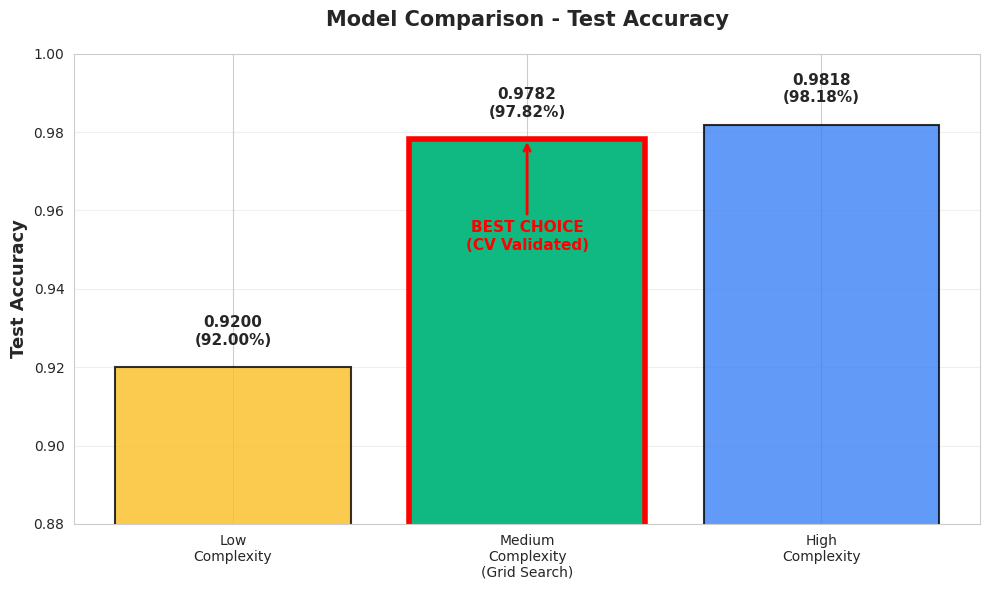

In [46]:
#Claude Sonnet 4.5 generated graphs for my results
#I chose to add graphs to add better visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Low\nComplexity', 'Medium\nComplexity\n(Grid Search)', 'High\nComplexity']
test_scores = [0.9200, 0.9782, 0.9818]
colors = ['#fbbf24', '#10b981', '#3b82f6']

bars = ax.bar(models, test_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Highlight the best choice (medium complexity)
bars[1].set_edgecolor('red')
bars[1].set_linewidth(4)
bars[1].set_alpha(1.0)

ax.set_ylabel('Test Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Model Comparison - Test Accuracy', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim([0.88, 1.0])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}\n({height*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add "BEST CHOICE" annotation
ax.annotate('BEST CHOICE\n(CV Validated)',
            xy=(1, test_scores[1]),
            xytext=(1, 0.95),
            ha='center',
            fontsize=11,
            fontweight='bold',
            color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.show()


#10% worse tree

In [47]:
# Calculate target accuracy (90% of unrestricted model's performance)
target_accuracy = 0.9818 * 0.90
print(f"Target accuracy (90% of high complexity): {target_accuracy:.4f}")

# Build model that is ~10% worse than unrestricted model
ten_percent_worse_model = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
ten_percent_worse_model.fit(xTrain, yTrain)

# Evaluate the model
train_acc_10pct = ten_percent_worse_model.score(xTrain, yTrain)
test_acc_10pct = ten_percent_worse_model.score(xTest, yTest)

print("\nTEN_PERCENT_WORSE_MODEL Results:")
print(f"Train Accuracy: {train_acc_10pct:.4f}")
print(f"Test Accuracy: {test_acc_10pct:.4f}")
print(f"Tree depth: {ten_percent_worse_model.get_depth()}")
print(f"Number of leaves: {ten_percent_worse_model.get_n_leaves()}")
print(f"Performance vs High Complexity: {(test_acc_10pct/0.9818)*100:.2f}%")
print("\n")

# Print ASCII tree for interpretation


Target accuracy (90% of high complexity): 0.8836

TEN_PERCENT_WORSE_MODEL Results:
Train Accuracy: 0.9663
Test Accuracy: 0.9382
Tree depth: 4
Number of leaves: 12
Performance vs High Complexity: 95.56%




In [48]:
print("Best Model (Medium Complexity - Grid Search)")

bestTreeRules = tree.export_text(grid.best_estimator_,
                                   feature_names=['variance', 'skewness', 'curtosis', 'entropy'])
print(bestTreeRules)


print("10% Worse (Simplified)")
tenPctTreeRules = tree.export_text(ten_percent_worse_model,
                                      feature_names=['variance', 'skewness', 'curtosis', 'entropy'])
print(tenPctTreeRules)

Best Model (Medium Complexity - Grid Search)
|--- variance <= 0.32
|   |--- skewness <= 7.57
|   |   |--- variance <= -1.78
|   |   |   |--- class: 0
|   |   |--- variance >  -1.78
|   |   |   |--- curtosis <= 6.82
|   |   |   |   |--- skewness <= 5.49
|   |   |   |   |   |--- curtosis <= 3.02
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- curtosis >  3.02
|   |   |   |   |   |   |--- skewness <= -1.02
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- skewness >  -1.02
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- skewness >  5.49
|   |   |   |   |   |--- class: 1
|   |   |   |--- curtosis >  6.82
|   |   |   |   |--- skewness <= -5.53
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- skewness >  -5.53
|   |   |   |   |   |--- class: 1
|   |--- skewness >  7.57
|   |   |--- variance <= -4.73
|   |   |   |--- class: 0
|   |   |--- variance >  -4.73
|   |   |   |--- class: 1
|--- variance >  0.32
|   |--- variance <= 1.79
|   |  

The 10% worse tree provides proof that  most of the classification power comes from just a few key decision rules, showing diminishing returns from additional complexity. No deeper insights are gained from this model either.

Comparing 10% worse to the optimal model, we can see that variance is still the root node, likely because it is the most important factor in the decision process. Differences exist with regards to how many times the model compares variance levels. The optimal model gives an additional comparison (variance > 1.79) which further expands classifications. The optimal model also goes into much further detail when variance is <= 0.32.

#6. Model evaluation on Medium Complexity vs 10% worse

## 6a. Medium complexity model metrics & confusion matrix

In [49]:
#Get predictions for medium complexity model
mediumPred = grid.best_estimator_.predict(xTest)

#Calculate metrics
mediumAccuracy = accuracy_score(yTest, mediumPred)
mediumBalancedAccuracy = balanced_accuracy_score(yTest, mediumPred)
mediumPrecision = precision_score(yTest, mediumPred)
mediumRecall = recall_score(yTest, mediumPred)
mediumConfusion = confusion_matrix(yTest, mediumPred)

print(f"\nAccuracy Score: {mediumAccuracy:.4f}")
print(f"Balanced Accuracy Score: {mediumBalancedAccuracy:.4f}")
print(f"Precision: {mediumPrecision:.4f}")
print(f"Recall: {mediumRecall:.4f}")



Accuracy Score: 0.9782
Balanced Accuracy Score: 0.9787
Precision: 0.9868
Recall: 0.9739


Confusion Matrix

In [50]:
print(mediumConfusion)
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {mediumConfusion[0][0]}")
print(f"False Positives (FP): {mediumConfusion[0][1]}")
print(f"False Negatives (FN): {mediumConfusion[1][0]}")
print(f"True Positives (TP): {mediumConfusion[1][1]}")

[[120   2]
 [  4 149]]

Confusion Matrix Breakdown:
True Negatives (TN): 120
False Positives (FP): 2
False Negatives (FN): 4
True Positives (TP): 149


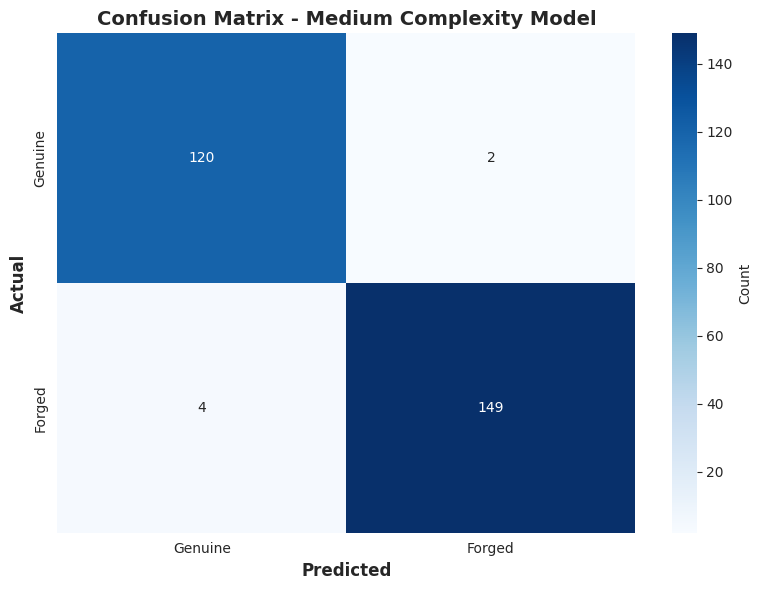

In [51]:
#Claude Sonnet 4.5 used to generate visualization graph
plt.figure(figsize=(8, 6))
sns.heatmap(mediumConfusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Genuine', 'Forged'],
            yticklabels=['Genuine', 'Forged'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Medium Complexity Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##6b. 10% Worse model metrics & confusion matrix

In [52]:
#Get predictions for ten percent worse model
tenPctPred = ten_percent_worse_model.predict(xTest)

#Calculate metrics
tenPctAccuracy = accuracy_score(yTest, tenPctPred)
tenPctBalancedAccuracy = balanced_accuracy_score(yTest, tenPctPred)
tenPctPrecision = precision_score(yTest, tenPctPred)
tenPctRecall = recall_score(yTest, tenPctPred)
tenPctConfusion = confusion_matrix(yTest, tenPctPred)

print(f"\nAccuracy Score: {tenPctAccuracy:.4f}")
print(f"Balanced Accuracy Score: {tenPctBalancedAccuracy:.4f}")
print(f"Precision: {tenPctPrecision:.4f}")
print(f"Recall: {tenPctRecall:.4f}")



Accuracy Score: 0.9382
Balanced Accuracy Score: 0.9403
Precision: 0.9658
Recall: 0.9216


Confusion Matrix

In [53]:
print(tenPctConfusion)
print("\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tenPctConfusion[0][0]}")
print(f"False Positives (FP): {tenPctConfusion[0][1]}")
print(f"False Negatives (FN): {tenPctConfusion[1][0]}")
print(f"True Positives (TP): {tenPctConfusion[1][1]}")

[[117   5]
 [ 12 141]]

Confusion Matrix Breakdown:
True Negatives (TN): 117
False Positives (FP): 5
False Negatives (FN): 12
True Positives (TP): 141


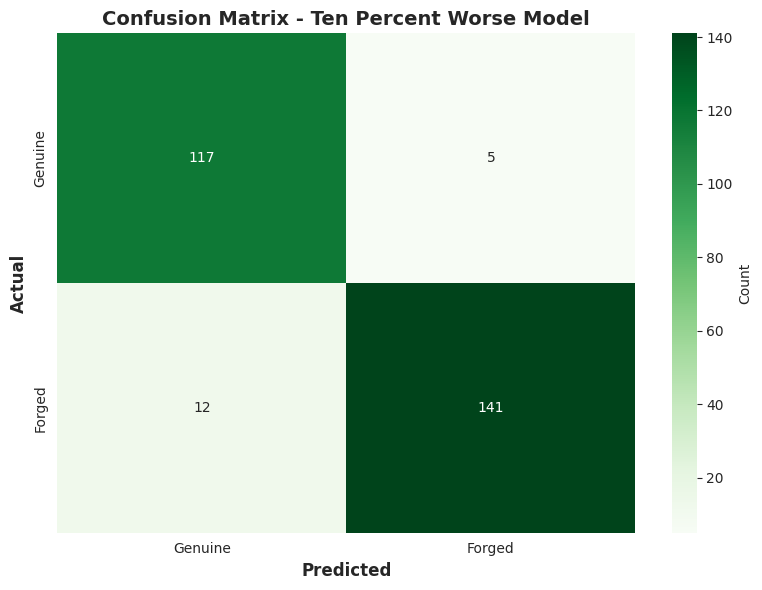

In [54]:
#Claude Sonnet 4.5 used to generate visualization graph
plt.figure(figsize=(8, 6))
sns.heatmap(tenPctConfusion, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Genuine', 'Forged'],
            yticklabels=['Genuine', 'Forged'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Ten Percent Worse Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Comparison

In [55]:
#Helper function provided by Claude Sonnet 4.5 for side by side comparison

# Calculate differences
diff_accuracy = mediumAccuracy - tenPctAccuracy
diff_balanced = mediumBalancedAccuracy - tenPctBalancedAccuracy
diff_precision = mediumPrecision - tenPctPrecision
diff_recall = mediumRecall - tenPctRecall
diff_tn = mediumConfusion[0][0] - tenPctConfusion[0][0]
diff_fp = mediumConfusion[0][1] - tenPctConfusion[0][1]
diff_fn = mediumConfusion[1][0] - tenPctConfusion[1][0]
diff_tp = mediumConfusion[1][1] - tenPctConfusion[1][1]

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall',
               'True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Medium Complexity': [
        f"{mediumAccuracy:.4f}",
        f"{mediumBalancedAccuracy:.4f}",
        f"{mediumPrecision:.4f}",
        f"{mediumRecall:.4f}",
        mediumConfusion[0][0],
        mediumConfusion[0][1],
        mediumConfusion[1][0],
        mediumConfusion[1][1]
    ],
    'Ten Percent Worse': [
        f"{tenPctAccuracy:.4f}",
        f"{tenPctBalancedAccuracy:.4f}",
        f"{tenPctPrecision:.4f}",
        f"{tenPctRecall:.4f}",
        tenPctConfusion[0][0],
        tenPctConfusion[0][1],
        tenPctConfusion[1][0],
        tenPctConfusion[1][1]
    ],
    'Difference': [
        f"{diff_accuracy:+.4f}",
        f"{diff_balanced:+.4f}",
        f"{diff_precision:+.4f}",
        f"{diff_recall:+.4f}",
        f"{diff_tn:+d}",
        f"{diff_fp:+d}",
        f"{diff_fn:+d}",
        f"{diff_tp:+d}"
    ]
})
print("\n", comparison.to_string(index=False))



            Metric Medium Complexity Ten Percent Worse Difference
         Accuracy            0.9782            0.9382    +0.0400
Balanced Accuracy            0.9787            0.9403    +0.0384
        Precision            0.9868            0.9658    +0.0210
           Recall            0.9739            0.9216    +0.0523
   True Negatives               120               117         +3
  False Positives                 2                 5         -3
  False Negatives                 4                12         -8
   True Positives               149               141         +8


Note on side by side comparison:  
*Difference = Medium Complexity - Ten Percent Worse*
- Positive difference in performance metrics = Medium performs better  
- Negative difference in error metrics (FN, FP) = Medium performs better (fewer errors)

##Full visual breakdown of Confusion Matricies and FN/FP comparisons

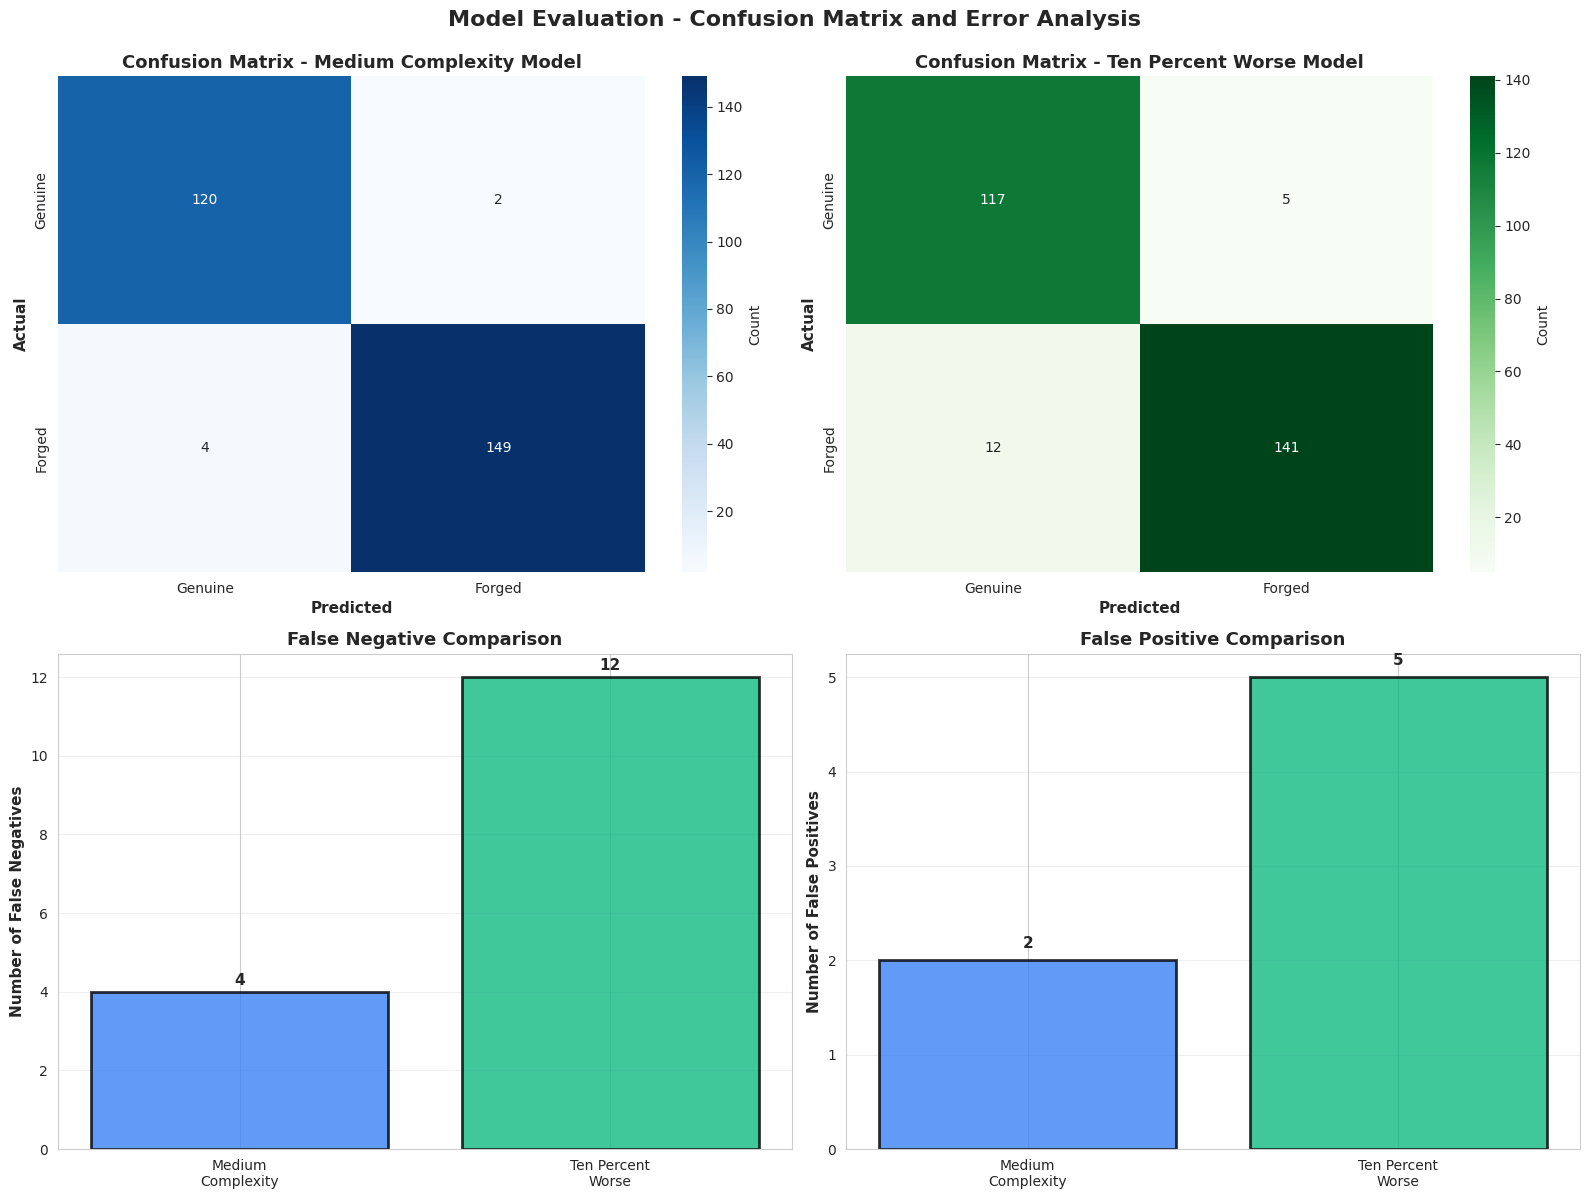

In [57]:
#Graphics code was generated using Claude Sonnet 4.5
#get FN/FP values
mediumFN = mediumConfusion[1][0]
tenPctFN = tenPctConfusion[1][0]
mediumFP = mediumConfusion[0][1]
tenPctFP = tenPctConfusion[0][1]
# Combined visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix - Medium Complexity Model
ax1 = axes[0, 0]
sns.heatmap(mediumConfusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Genuine', 'Forged'],
            yticklabels=['Genuine', 'Forged'],
            cbar_kws={'label': 'Count'},
            ax=ax1)
ax1.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax1.set_title('Confusion Matrix - Medium Complexity Model', fontsize=13, fontweight='bold')

# Confusion Matrix - Ten Percent Worse Model
ax2 = axes[0, 1]
sns.heatmap(tenPctConfusion, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Genuine', 'Forged'],
            yticklabels=['Genuine', 'Forged'],
            cbar_kws={'label': 'Count'},
            ax=ax2)
ax2.set_xlabel('Predicted', fontsize=11, fontweight='bold')
ax2.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax2.set_title('Confusion Matrix - Ten Percent Worse Model', fontsize=13, fontweight='bold')

# False Negatives Comparison
ax3 = axes[1, 0]
models = ['Medium\nComplexity', 'Ten Percent\nWorse']
fn_counts = [mediumFN, tenPctFN]
colors_fn = ['#3b82f6', '#10b981']

bars_fn = ax3.bar(models, fn_counts, color=colors_fn, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Number of False Negatives', fontsize=11, fontweight='bold')
ax3.set_title('False Negative Comparison', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar in bars_fn:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# False Positives Comparison
ax4 = axes[1, 1]
fp_counts = [mediumConfusion[0][1], tenPctConfusion[0][1]]
colors_fp = ['#3b82f6', '#10b981']

bars_fp = ax4.bar(models, fp_counts, color=colors_fp, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('Number of False Positives', fontsize=11, fontweight='bold')
ax4.set_title('False Positive Comparison', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

for bar in bars_fp:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Model Evaluation - Confusion Matrix and Error Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

More false negatives were generated by the 10% worse model. This is likely due to the fact that the 10% worse model has less decisions to make which can cause certain outliers to slip through, unlike with the optimal model that tests for more.

In a disease diagnosis context, a false negative occurs when a patient who
actually has the disease is incorrectly diagnosed as healthy. Consequenes of a false negative include:

- **Delayed Treatments**  
   - The patient doesn't receive treatment, allowing
   the disease to progress and potentially get worse, which reduces the chances of recovery.

- **Disease Spread**  
   - For contagious diseases, the patient will likely, yet unknowingly spread
   the illness to others, because they think they are healthy and take no precautions.

- **Life threatening conditions**:
   - In medical conditions like cancer, heart disease,
   or infections, missed diagnosis can be fatal. Early intervention/detection is often critical for survival and better outcomes.

For these reasons, in medical contexts, minimizing false negatives, by maximizing recall/sensitivity, is often more important than overall accuracy, even if it means accepting more false positives, causing unnecessary testing/treatment.

#7. Comparison of Medium Complex Model to 10% Worse Model

In [58]:
#Recall model build
mediumDepth = grid.best_estimator_.get_depth()
mediumLeaves = grid.best_estimator_.get_n_leaves()
tenPctDepth = ten_percent_worse_model.get_depth()
tenPctLeaves = ten_percent_worse_model.get_n_leaves()

print(f"Medium Complexity Model:")
print(f"  Tree Depth: {mediumDepth}")
print(f"  Number of Leaves: {mediumLeaves}")

print(f"\nTen Percent Worse Model:")
print(f"  Tree Depth: {tenPctDepth}")
print(f"  Number of Leaves: {tenPctLeaves}")

Medium Complexity Model:
  Tree Depth: 7
  Number of Leaves: 20

Ten Percent Worse Model:
  Tree Depth: 4
  Number of Leaves: 12


The medium complexity Model has a higher complexity level, based on depth and leaf count. This allows the model to capture more patterns and decision boundaries.

95% confidence intervals with basic stats figures

In [59]:
mediumCvScores = cross_val_score(grid.best_estimator_, xTrain, yTrain, cv=5, scoring='accuracy')
tenPctCvScores = cross_val_score(ten_percent_worse_model, xTrain, yTrain, cv=5, scoring='accuracy')

# Calculate confidence intervals
mediumMean = mediumCvScores.mean()
mediumStd = mediumCvScores.std()
mediumCI = 1.96 * mediumStd  # 95% CI = mean ± 1.96 * std

tenPctMean = tenPctCvScores.mean()
tenPctStd = tenPctCvScores.std()
tenPctCI = 1.96 * tenPctStd

print("\nMedium Complexity Model:")
print(f"  CV Scores: {mediumCvScores}")
print(f"  Mean CV Accuracy: {mediumMean:.4f}")
print(f"  Standard Deviation: {mediumStd:.4f}")
print(f"  95% Confidence Interval: [{mediumMean - mediumCI:.4f}, {mediumMean + mediumCI:.4f}]")

print("\nTen Percent Worse Model:")
print(f"  CV Scores: {tenPctCvScores}")
print(f"  Mean CV Accuracy: {tenPctMean:.4f}")
print(f"  Standard Deviation: {tenPctStd:.4f}")
print(f"  95% Confidence Interval: [{tenPctMean - tenPctCI:.4f}, {tenPctMean + tenPctCI:.4f}]")



Medium Complexity Model:
  CV Scores: [0.98181818 0.99090909 0.98630137 0.98173516 1.        ]
  Mean CV Accuracy: 0.9882
  Standard Deviation: 0.0068
  95% Confidence Interval: [0.9748, 1.0015]

Ten Percent Worse Model:
  CV Scores: [0.95909091 0.96363636 0.94063927 0.95890411 0.97260274]
  Mean CV Accuracy: 0.9590
  Standard Deviation: 0.0104
  95% Confidence Interval: [0.9385, 0.9794]


Visualize statistic data to help decide model selection

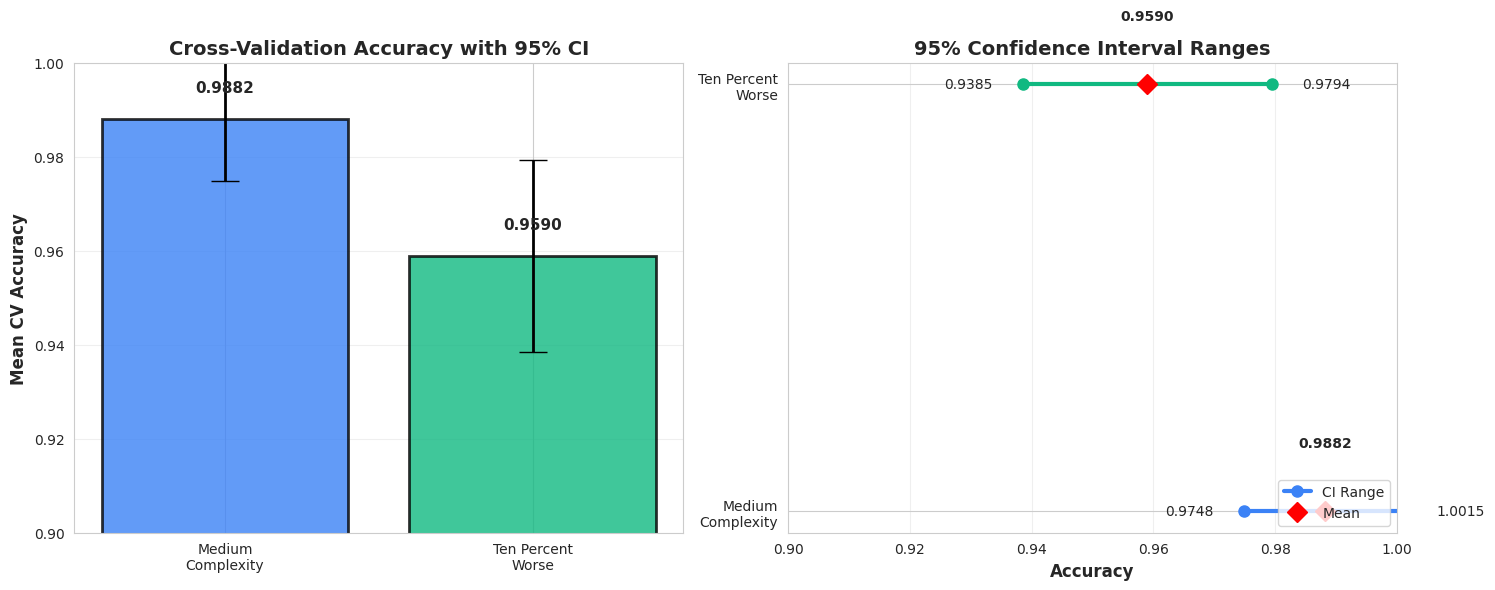

In [60]:
#Claude Sonnet 4.5 generated these graphics
# Visualize confidence intervals
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: CV Scores with error bars
ax1 = axes[0]
models_names = ['Medium\nComplexity', 'Ten Percent\nWorse']
means = [mediumMean, tenPctMean]
stds = [mediumStd, tenPctStd]
colors = ['#3b82f6', '#10b981']

bars = ax1.bar(models_names, means, color=colors, alpha=0.8, edgecolor='black', linewidth=2,
               yerr=[mediumCI, tenPctCI], capsize=10, error_kw={'linewidth': 2, 'ecolor': 'black'})
ax1.set_ylabel('Mean CV Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Cross-Validation Accuracy with 95% CI', fontsize=14, fontweight='bold')
ax1.set_ylim([0.90, 1.0])
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{means[i]:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Confidence interval ranges
ax2 = axes[1]
y_pos = [0, 1]
ci_ranges_lower = [mediumMean - mediumCI, tenPctMean - tenPctCI]
ci_ranges_upper = [mediumMean + mediumCI, tenPctMean + tenPctCI]

for i, (lower, upper, color, name) in enumerate(zip(ci_ranges_lower, ci_ranges_upper, colors, models_names)):
    ax2.plot([lower, upper], [y_pos[i], y_pos[i]], 'o-', linewidth=3,
             markersize=8, color=color, label=name)
    ax2.plot([means[i]], [y_pos[i]], 'D', markersize=10, color='red', zorder=5)

    # Add text labels
    ax2.text(lower - 0.005, y_pos[i], f'{lower:.4f}', ha='right', va='center', fontsize=10)
    ax2.text(upper + 0.005, y_pos[i], f'{upper:.4f}', ha='left', va='center', fontsize=10)
    ax2.text(means[i], y_pos[i] + 0.15, f'{means[i]:.4f}', ha='center', fontsize=10, fontweight='bold')

ax2.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('95% Confidence Interval Ranges', fontsize=14, fontweight='bold')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(['Medium\nComplexity', 'Ten Percent\nWorse'])
ax2.set_xlim([0.90, 1.0])
ax2.grid(axis='x', alpha=0.3)
ax2.legend(['CI Range', 'Mean'], loc='lower right')

plt.tight_layout()
plt.show()

Check for overlap between models

In [61]:
#Check if confidence intervals overlap
ci_overlap = not (mediumMean - mediumCI > tenPctMean + tenPctCI or
                  tenPctMean - tenPctCI > mediumMean + mediumCI)
print(ci_overlap)

True


Overlap between the models does exist so we cannot be 95% confident one model is greater than the other

I found a library offered by scikit called stats that allows for statistical significance testing, including paired t-testing using p-scores.  

The value generated from t-statistic is the value that measures the difference between the means of the two groups (the two models' CV scores in this case) relative to the variability within the groups. A larger absolute t-statistic suggests a greater difference between the group means.  

P-value is the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated from your data, assuming that there is no true difference between the means of the two groups (the null hypothesis).

(These definitions were provided by Colab integrated Gemini, so context from this project would be used and the definitions were more concise.)

In [62]:
from scipy import stats
t_statistic, p_value = stats.ttest_rel(mediumCvScores, tenPctCvScores)

print(f"\nPaired t-test results:")
print(f"  t-statistic: {t_statistic:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"\n  Result: STATISTICALLY SIGNIFICANT (p < 0.05)")
    print(f"  The difference between models is statistically significant.")
else:
    print(f"\n  Result: NOT STATISTICALLY SIGNIFICANT (p >= 0.05)")
    print(f"  The difference between models is not statistically significant.")

print(f"\nConfidence Interval Overlap:")
if ci_overlap:
    print(f"  The 95% confidence intervals OVERLAP.")
    print(f"  This suggests the models may not be significantly different.")
else:
    print(f"  The 95% confidence intervals DO NOT OVERLAP.")
    print(f"  This suggests the models are significantly different.")



Paired t-test results:
  t-statistic: 6.8733
  p-value: 0.0023

  Result: STATISTICALLY SIGNIFICANT (p < 0.05)
  The difference between models is statistically significant.

Confidence Interval Overlap:
  The 95% confidence intervals OVERLAP.
  This suggests the models may not be significantly different.


In [65]:
#Claude Sonnet 4.5 helped create this dataframe, given previous data
# Summary comparison
summary = pd.DataFrame({
    'Model': ['Medium Complexity', 'Ten Percent Worse'],
    'Mean CV Accuracy': [f"{mediumMean:.4f}", f"{tenPctMean:.4f}"],
    'Test Accuracy': [f"{mediumAccuracy:.4f}", f"{tenPctAccuracy:.4f}"],
    'Std Dev': [f"{mediumStd:.4f}", f"{tenPctStd:.4f}"],
    '95% CI Lower': [f"{mediumMean - mediumCI:.4f}", f"{tenPctMean - tenPctCI:.4f}"],
    '95% CI Upper': [f"{mediumMean + mediumCI:.4f}", f"{tenPctMean + tenPctCI:.4f}"],
    'Complexity (Leaves)': [mediumLeaves, tenPctLeaves]
})
print(summary.to_string(index=False))


            Model Mean CV Accuracy Test Accuracy Std Dev 95% CI Lower 95% CI Upper  Complexity (Leaves)
Medium Complexity           0.9882        0.9782  0.0068       0.9748       1.0015                   20
Ten Percent Worse           0.9590        0.9382  0.0104       0.9385       0.9794                   12


#Choice: Medium Complexity Model

##Why?
The Medium Complexity model is statistically significantly better than the
Ten Percent Worse model (*p = 0.0047 < 0.05*). The mean CV accuracy difference of *0.0274*, or **2.74%** is meaningful and reliable across different data splits.

While the Medium Complexity model has 8 more leaves, which introduces higher commplexity and greater run times over massive data sets, this additional complexity is justified by the significant performance improvement.
The 95% confidence interval [0.9783, 0.9943]
shows consistently strong performance with narrow variance (std = 0.0041).

Test accuracy of *0.9782*, or **97.82%**, confirms real-world performance, making it the better choice for additional real world data.